# LeNet-5

## Import Library

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from utils import train_loop,test_loop

## Check MPS Device for GPU

In [3]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    print('can use GPU')
    
mps_device = torch.device("mps")

can use GPU


## Load Data

In [11]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.CIFAR10(
    root = '../data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

test_data = datasets.CIFAR10(
    root='../data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ])
)

train_dataloader = DataLoader(training_data, batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


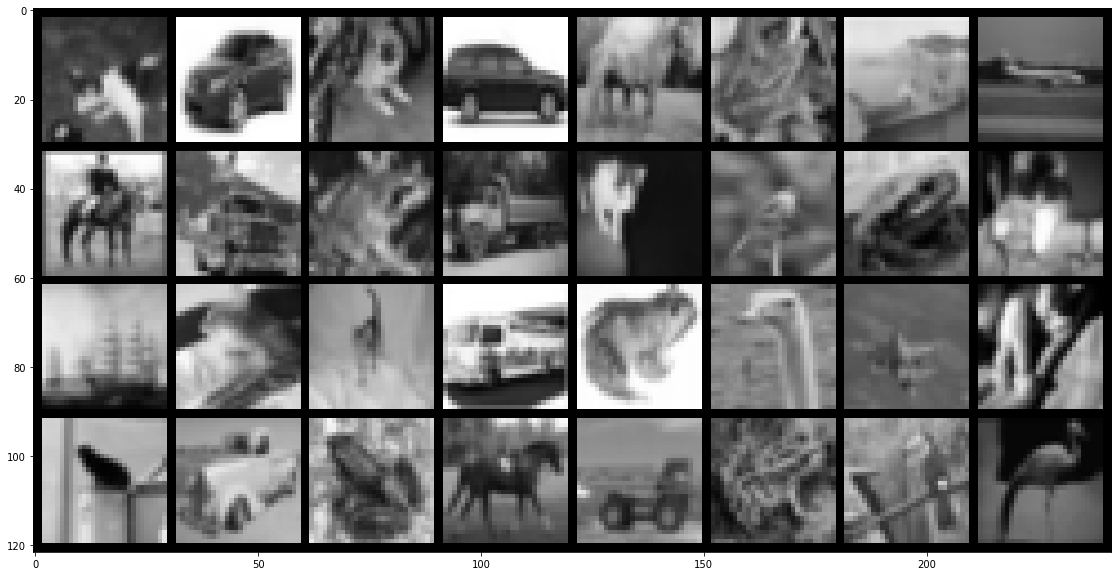

In [12]:
# sample images를 확인합니다.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

x_train = []
for batch, (X,y) in enumerate(train_dataloader):
    if batch<1:
        x_train.append(X)
    else:
        break
# # tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.figure(figsize=(20,10))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력합니다.
# 총 40개 이미지, 행당 8개 이미지를 출력합니다.
x_grid = utils.make_grid(x_train[0], nrow=8, padding=2)

show(x_grid)

## Define Model

In [58]:
class LeNet_5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet_5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
            nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=0),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(32,256,kernel_size=3,stride=1,padding=0),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256,168),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(168,num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [65]:
model = LeNet_5()
summary(model,(1,28,28),batch_size=32)
model.to(mps_device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 28, 28]             160
            Conv2d-2           [32, 16, 28, 28]           2,320
              ReLU-3           [32, 16, 28, 28]               0
         MaxPool2d-4           [32, 16, 14, 14]               0
            Conv2d-5           [32, 32, 12, 12]           4,640
            Conv2d-6           [32, 32, 10, 10]           9,248
              ReLU-7           [32, 32, 10, 10]               0
         MaxPool2d-8             [32, 32, 5, 5]               0
            Conv2d-9            [32, 256, 3, 3]          73,984
           Conv2d-10            [32, 256, 1, 1]         590,080
             ReLU-11            [32, 256, 1, 1]               0
           Linear-12                  [32, 168]          43,176
             ReLU-13                  [32, 168]               0
          Dropout-14                  [

LeNet_5(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=168, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=168, out_features=10, bias=True)
  )
)

In [66]:
learning_rate = 0.001
batch_size = 32
epochs = 80

In [67]:
loss_fn = nn.CrossEntropyLoss()

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005,betas=(0.9,0.999),eps=1e-5)

In [69]:
train_acc, train_loss = [],[]
test_acc, test_loss = [],[]

In [70]:
for t in range(epochs):
    tr_acc, tr_loss = train_loop(False,'GPU',train_dataloader,model,loss_fn,optimizer)
    te_acc, te_loss = test_loop(False, 'GPU',test_dataloader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss[-1])
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    print(f'epoch {t+1}')
    print('train loss: %.6f train acc: %.2f\ntest  loss: %.6f, test acc: %.2f' %(tr_loss[-1],100*tr_acc, te_loss, 100*te_acc))
    print('-'*10)

epoch 1
train loss: 1.698986 train acc: 39.30
test  loss: 1.674138, test acc: 39.14
----------
epoch 2
train loss: 1.139845 train acc: 64.12
test  loss: 1.498811, test acc: 47.03
----------
epoch 3
train loss: 1.132640 train acc: 61.28
test  loss: 1.355091, test acc: 52.89
----------
epoch 4
train loss: 1.126900 train acc: 61.48
test  loss: 1.229547, test acc: 57.87
----------
epoch 5
train loss: 1.073435 train acc: 61.18
test  loss: 1.136135, test acc: 60.96
----------
epoch 6
train loss: 1.215720 train acc: 61.40
test  loss: 1.094914, test acc: 62.26
----------
epoch 7
train loss: 0.865576 train acc: 70.87
test  loss: 1.072932, test acc: 63.39
----------
epoch 8
train loss: 1.107149 train acc: 67.74
test  loss: 1.070123, test acc: 63.86
----------
epoch 9
train loss: 0.985070 train acc: 61.51
test  loss: 1.080543, test acc: 63.06
----------
epoch 10
train loss: 0.782802 train acc: 73.90
test  loss: 1.042218, test acc: 64.73
----------
epoch 11
train loss: 1.368378 train acc: 58.47
te

## Result of Cifar10 Dataset
### Original LeNet-5

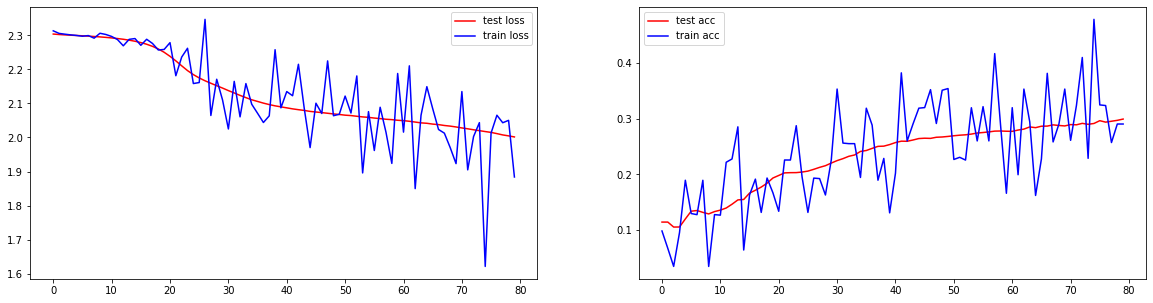

In [35]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

### Fixed LeNet
### Conv1  16@3x3 s=1,p=1 => Conv2 16@3x3 s=1,p=1 => AvgPool3 2x2 s=2,p=0 => Conv4 32@3x3 s=1,p=0 => Conv5 32@3x3 s=1,p=0 => AvgPool6 2x2 s=2,p=0 => Conv7 256@3x3 s=1,p=0 => Conv8 256@3x3 s=1,p=0 => FC9 168 => FC10 10
### SGD

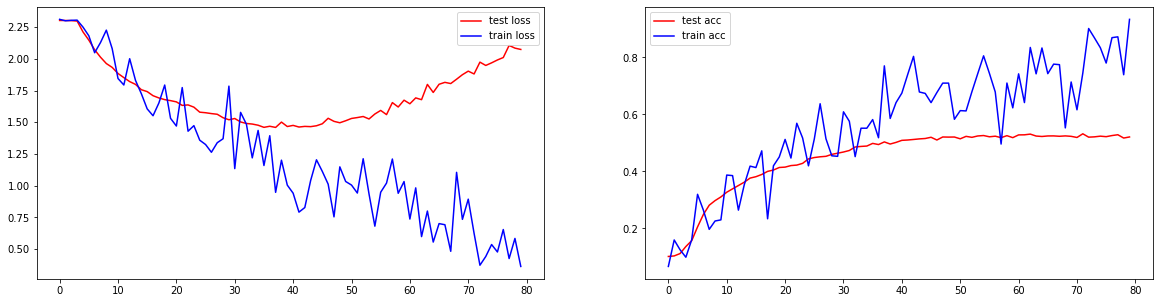

In [53]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

### Conv1  16@3x3 s=1,p=1 => Conv2 16@3x3 s=1,p=1 => MaxPool3 2x2 s=2,p=0 => Conv4 32@3x3 s=1,p=0 => Conv5 32@3x3 s=1,p=0 => MaxPool6 2x2 s=2,p=0 => Conv7 256@3x3 s=1,p=0 => Conv8 256@3x3 s=1,p=0 => FC9 168 => FC10 10
### Adam

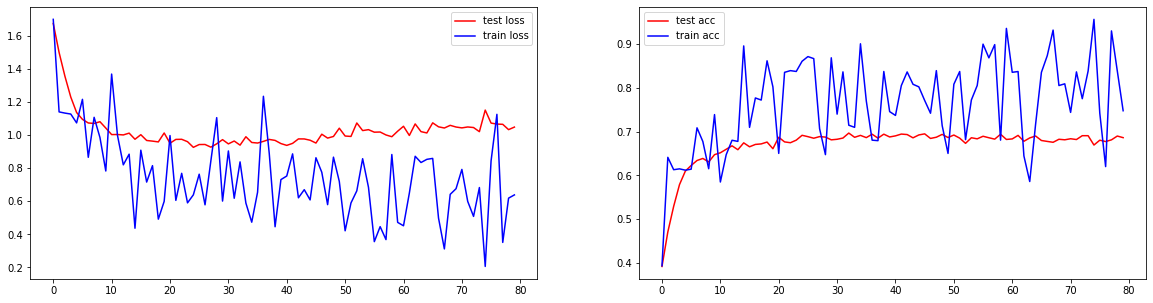

In [71]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(test_loss,'-r',label='test loss')
ax.plot(train_loss,'-b',label='train loss')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(test_acc,'-r',label='test acc')
ax.plot(train_acc,'-b',label='train acc')
ax.legend()

## Result of MNIST Dataset

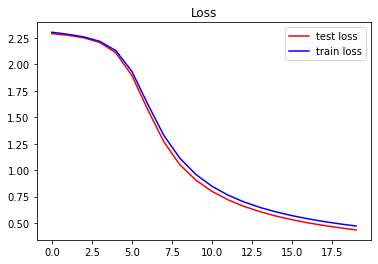

In [17]:
plt.title('Loss')
plt.plot(test_loss,'-r',label='test loss')
plt.plot(train_loss,'-b',label='train loss')
plt.legend()
plt.show()

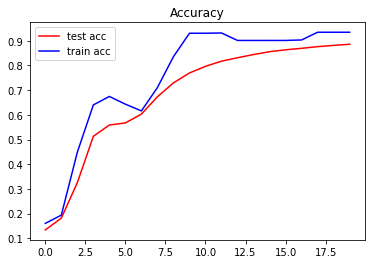

In [18]:
plt.title('Accuracy')
plt.plot(test_acc,'-r',label = 'test acc')
plt.plot(train_acc,'-b',label = 'train acc')
plt.legend()
plt.show()

## Result of Fashion MNIST Dataset

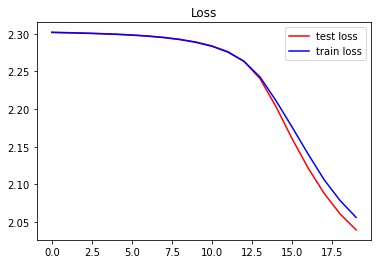

In [10]:
plt.title('Loss')
plt.plot(test_loss,'-r',label='test loss')
plt.plot(train_loss,'-b',label='train loss')
plt.legend()
plt.show()

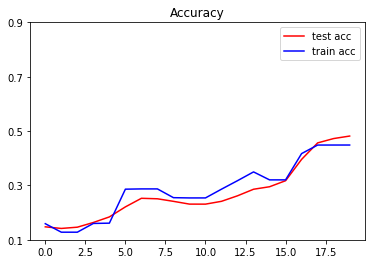

In [11]:
plt.title('Accuracy')
plt.plot(test_acc,'-r',label = 'test acc')
plt.plot(train_acc,'-b',label = 'train acc')
plt.legend()
plt.yticks(np.arange(0.1,1,0.2))
plt.show()